<a href="https://colab.research.google.com/github/Paul-Bett/Kamureito_Dopers_Management_System/blob/main/notebooks/Kamureito_Doper_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup: Import Libraries

In [1]:
# Import necessary libraries
import sqlite3              # For database operations with SQLite
import pandas as pd         # For viewing and analyzing tabular data
from datetime import datetime, timedelta  # For handling dates
import uuid                 # For generating unique IDs

# This setup ensures we're ready to use SQLite as our backend for storing sheep, events, and user information,
# and pandas for viewing and analyzing results.


#2. Database Initialization and Schema Creation

In [2]:
# Connect to (or create) the SQLite database file
conn = sqlite3.connect("sheep_management.db")
cursor = conn.cursor()

# Sheep Table: Stores details about each sheep
cursor.execute("""
CREATE TABLE IF NOT EXISTS sheep (
    id TEXT PRIMARY KEY,
    name TEXT,
    birth_date TEXT,
    ewe_id TEXT,    -- mother (female)
    ram_id TEXT,    -- father (male)
    breed TEXT,
    gender TEXT,
    tag_id TEXT,
    status TEXT,
    notes TEXT
)
""")

# Event Table: Logs all events related to sheep
cursor.execute("""
CREATE TABLE IF NOT EXISTS events (
    event_id TEXT PRIMARY KEY,
    sheep_id TEXT,
    event_type TEXT,
    event_date TEXT,
    details TEXT
)
""")

# Mating and Breeding Schedule Table
cursor.execute("""
CREATE TABLE IF NOT EXISTS breeding (
    breeding_id TEXT PRIMARY KEY,
    female_id TEXT,
    male_id TEXT,
    suggested_mating_date TEXT,
    gestation_due_date TEXT,
    status TEXT,
    notes TEXT
)
""")

# User Table: Multi-user management
cursor.execute("""
CREATE TABLE IF NOT EXISTS users (
    user_id TEXT PRIMARY KEY,
    name TEXT,
    role TEXT
)
""")

conn.commit()
# This cell sets up the database with the core tables: sheep, events, breeding, and users.


#3. Sheep Registration Function

In [3]:


def register_sheep(name, birth_date, ewe_id, ram_id, breed, gender, tag_id, status="alive", notes=""):
    # Check for existing tag linked to a live sheep
    cursor.execute("SELECT status FROM sheep WHERE tag_id = ?", (tag_id,))
    existing = cursor.fetchone()
    if existing:
        if existing[0] == "alive":
            return f"Registration failed: Tag ID '{tag_id}' is already assigned to a live sheep currently in the farm."
        # If the sheep is dead/sold, tag can be reused
    sheep_id = str(uuid.uuid4())
    cursor.execute("""
        INSERT INTO sheep (id, name, birth_date, ewe_id, ram_id, breed, gender, tag_id, status, notes)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (sheep_id, name, birth_date, ewe_id, ram_id, breed, gender, tag_id, status, notes))
    conn.commit()
    return f"Registration successful: ID = {sheep_id}, Tag ID = {tag_id}"


# This function allows you to register new sheep and returns their unique ID.


150 Dopers added to the DB

In [4]:
import random

colors = ['R', 'B', 'Y', 'G', 'O']
breeds = ['Doper']#[],'Merino', 'Suffolk', 'Hampshire', 'Texel', 'Cheviot']
genders = ['male', 'female']

def random_tag():
    return f"{random.choice(colors)}{random.randint(0,99):02d}"

# Step 1: Add 30 sourced sheep
sourced_ids = []
for i in range(30):
    sheep_id = register_sheep(
        name=f"SourcedSheep_{i+1}",
        birth_date=f"2019-{random.randint(1,12):02d}-{random.randint(1,28):02d}",
        ewe_id=None,
        ram_id=None,
        breed=random.choice(breeds),
        gender=random.choice(genders),
        tag_id=random_tag()
    )
    sourced_ids.append(sheep_id)

# Step 2: Seed founders (generation 1, base parents)
gen_dict = {1: []}
for i in range(10):  # 10 base mothers (ewes)
    ewe_id = register_sheep(
        name=f"FounderEwe_{i+1}",
        birth_date="2019-01-01",
        ewe_id=None,
        ram_id=None,
        breed=random.choice(breeds),
        gender="female",
        tag_id=random_tag()
    )
    gen_dict[1].append(ewe_id)
for i in range(10):  # 10 base fathers (rams)
    ram_id = register_sheep(
        name=f"FounderRam_{i+1}",
        birth_date="2019-01-01",
        ewe_id=None,
        ram_id=None,
        breed=random.choice(breeds),
        gender="male",
        tag_id=random_tag()
    )
    gen_dict[1].append(ram_id)

# Step 3: Add generations 2-6
total_sheep_added = len(sourced_ids) + len(gen_dict[1])
curr_sheep_ids = gen_dict[1].copy()

for gen in range(2, 7):
    gen_dict[gen] = []
    offspring_count = min(((150-total_sheep_added)//(7-gen)), 20)
    for i in range(offspring_count):
        mother_id = random.choice([sid for sid in curr_sheep_ids if sid is not None and genders[random.randint(0,1)] == 'female'])
        father_id = random.choice([sid for sid in curr_sheep_ids if sid is not None and genders[random.randint(0,1)] == 'male'])
        sheep_id = register_sheep(
            name=f"Gen{gen}Sheep_{i+1}",
            birth_date=f"{2019+gen}-{random.randint(1,12):02d}-{random.randint(1,28):02d}",
            ewe_id=mother_id,
            ram_id=father_id,
            breed=random.choice(breeds),
            gender=random.choice(genders),
            tag_id=random_tag()
        )
        gen_dict[gen].append(sheep_id)
        total_sheep_added += 1
    curr_sheep_ids += gen_dict[gen]

# Step 4: Fill up to 150 with extra offspring if needed, using all possible parents from gen 2-6
while total_sheep_added < 150:
    mother_id = random.choice([sid for sid in curr_sheep_ids if sid is not None])
    father_id = random.choice([sid for sid in curr_sheep_ids if sid is not None])
    sheep_id = register_sheep(
        name=f"ExtraSheep_{total_sheep_added+1}",
        birth_date=f"{2025}-{random.randint(1,12):02d}-{random.randint(1,28):02d}",
        ewe_id=mother_id,
        ram_id=father_id,
        breed=random.choice(breeds),
        gender=random.choice(genders),
        tag_id=random_tag()
    )
    total_sheep_added += 1

# Display final population
sheep_df = pd.read_sql_query("SELECT * FROM sheep", conn)
print(f"Total sheep in DB: {sheep_df.shape[0]}")
display(sheep_df)


Total sheep in DB: 143


,id,name,birth_date,ewe_id,ram_id,breed,gender,tag_id,status,notes
0,0d5e0733-6082-42d3-a192-96751771a5b8,SourcedSheep_1,2019-03-18,None,None,Doper,female,O25,alive,
1,25b6ca5a-5388-4a96-8d50-ce80bfc00817,SourcedSheep_2,2019-07-10,None,None,Doper,male,Y83,alive,
2,afeaa684-6291-4d0c-b48e-77eb926d9a0b,SourcedSheep_3,2019-02-20,None,None,Doper,male,G05,alive,
3,786e12ce-275a-4af1-90f2-f5d881efba9d,SourcedSheep_4,2019-05-11,None,None,Doper,female,G41,alive,
4,81e1c462-0090-47ce-bb30-a49c4fc92382,SourcedSheep_5,2019-03-20,None,None,Doper,female,Y56,alive,
...,...,...,...,...,...,...,...,...,...,...
138,34c158fc-6f5d-42e0-8c83-5e235a91c95d,Gen6Sheep_16,2025-06-08,Registration successful: ID = 1e7e08fb-ce81-4a...,Registration successful: ID = d59f0a42-eb27-48...,Doper,female,B51,alive,
139,d3f3fc6b-1998-4875-ba71-a43f80d2d6a5,Gen6Sheep_17,2025-02-04,Registration successful: ID = af08e3eb-e1a2-41...,Registration successful: ID = 92b133a3-2319-4b...,Doper,female,B39,alive,
140,0d94d21f-7fc2-4ecc-a75d-a7ac7e2d26be,Gen6Sheep_18,2025-02-18,Registration successful: ID = 30928454-83ab-40...,Registration successful: ID = 1e7e08fb-ce81-4a...,Doper,male,O05,alive,
141,a33ee13f-49c6-48df-8652-4bfc853fff89,Gen6Sheep_19,2025-03-15,Registration successful: ID = d59f0a42-eb27-48...,Registration successful: ID = 296624ba-eb61-4c...,Doper,female,R20,alive,


Randomize alive, dead and sold

In [17]:
# import random
# from datetime import datetime, timedelta

# # Ensure sheep_df is up-to-date, parsing 'birth_date' as dates
# sheep_df = pd.read_sql_query("SELECT * FROM sheep", conn, parse_dates=['birth_date'])

# # Get the total number of sheep
# total_sheep = sheep_df.shape[0]

# # Categorize sheep to identify lambs
# current_date = datetime.now()
# def is_lamb(row):
#     age_in_days = (current_date - row['birth_date']).days
#     return age_in_days <= 180 # Approximately 6 months

# sheep_df['is_lamb'] = sheep_df.apply(is_lamb, axis=1)

# # Separate sheep IDs into lambs and non-lambs
# lamb_ids = sheep_df[sheep_df['is_lamb'] == True]['id'].tolist()
# non_lamb_ids = sheep_df[sheep_df['is_lamb'] == False]['id'].tolist()

# # Calculate the number of non-lambs for each status based on percentages
# # Lambs will only be assigned 'alive' or 'dead'
# num_alive_non_lambs = int(len(non_lamb_ids) * 0.60)
# num_sold_non_lambs = int(len(non_lamb_ids) * 0.35)
# num_dead_non_lambs = len(non_lamb_ids) - num_alive_non_lambs - num_sold_non_lambs

# # Calculate the number of lambs for 'alive' and 'dead'
# num_alive_lambs = int(len(lamb_ids) * (0.60 / (0.60 + 0.05))) if (0.60 + 0.05) > 0 else 0 # Distribute the original 60% and 5% among lambs
# num_dead_lambs = len(lamb_ids) - num_alive_lambs


# # Shuffle the IDs within each group
# random.shuffle(non_lamb_ids)
# random.shuffle(lamb_ids)

# # Assign statuses to non-lambs
# alive_non_lamb_ids = non_lamb_ids[:num_alive_non_lambs]
# sold_non_lamb_ids = non_lamb_ids[num_alive_non_lambs : num_alive_non_lambs + num_sold_non_lambs]
# dead_non_lamb_ids = non_lamb_ids[num_alive_non_lambs + num_sold_non_lambs :]

# # Assign statuses to lambs
# alive_lamb_ids = lamb_ids[:num_alive_lambs]
# dead_lamb_ids = lamb_ids[num_alive_lambs :]


# # Combine the IDs for each status
# alive_ids = alive_non_lamb_ids + alive_lamb_ids
# sold_ids = sold_non_lamb_ids
# dead_ids = dead_non_lamb_ids + dead_lamb_ids


# # Update the status in the database
# cursor.execute("UPDATE sheep SET status='alive' WHERE id IN ({})".format(','.join('?' * len(alive_ids))), alive_ids)
# cursor.execute("UPDATE sheep SET status='sold' WHERE id IN ({})".format(','.join('?' * len(sold_ids))), sold_ids)
# cursor.execute("UPDATE sheep SET status='dead' WHERE id IN ({})".format(','.join('?' * len(dead_ids))), dead_ids)
# conn.commit()

# print(f"Updated statuses for {total_sheep} sheep:")
# print(f"- Alive: {len(alive_ids)}")
# print(f"- Sold: {len(sold_ids)}")
# print(f"- Dead: {len(dead_ids)}")

# # Verify the update by reading the data again
# updated_sheep_df = pd.read_sql_query("SELECT * FROM sheep", conn, parse_dates=['birth_date'])

# # Re-calculate 'is_lamb' column for the updated DataFrame
# updated_sheep_df['is_lamb'] = updated_sheep_df.apply(is_lamb, axis=1)

# print("\nUpdated Sheep Status Counts:")
# print(updated_sheep_df['status'].value_counts())

# # Verify that no lambs are marked as 'sold'
# lambs_sold = updated_sheep_df[(updated_sheep_df['is_lamb'] == True) & (updated_sheep_df['status'] == 'sold')]
# print(f"\nNumber of lambs with 'sold' status: {lambs_sold.shape[0]}")

Updated statuses for 145 sheep:
- Alive: 91
- Sold: 46
- Dead: 8

Updated Sheep Status Counts:
status
alive    91
sold     46
dead      8
Name: count, dtype: int64

Number of lambs with 'sold' status: 0


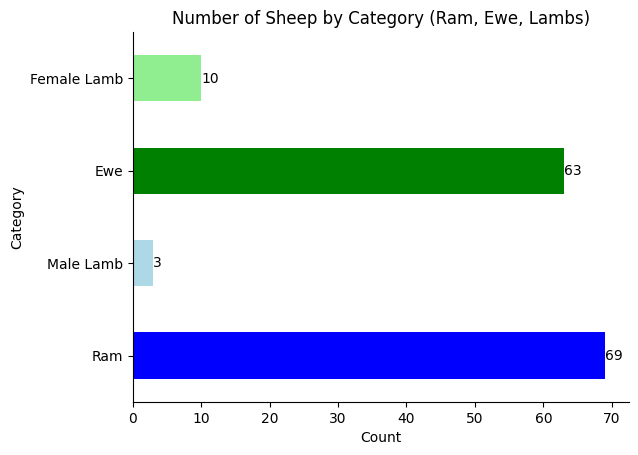

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

# Ensure sheep_df is up-to-date, parsing 'birth_date' as dates
sheep_df = pd.read_sql_query("SELECT * FROM sheep", conn, parse_dates=['birth_date'])

# Categorize sheep into Ram, Ewe, Male Lamb, and Female Lamb based on age and gender
current_date = datetime.now()
def categorize_sheep(row):
    age_in_days = (current_date - row['birth_date']).days
    if age_in_days <= 180: # Approximately 6 months
        if row['gender'] == 'male':
            return 'Male Lamb'
        elif row['gender'] == 'female':
            return 'Female Lamb'
        else:
            return 'Lamb (Unknown Gender)' # Handle unknown gender for lambs
    else: # Older than 6 months
        if row['gender'] == 'male':
            return 'Ram'
        elif row['gender'] == 'female':
            return 'Ewe'
        else:
            return 'Adult (Unknown Gender)' # Handle unknown gender for adults


sheep_df['category'] = sheep_df.apply(categorize_sheep, axis=1)


# Group by category and count the number of sheep
category_counts = sheep_df.groupby('category').size()

# Define custom colors for each category
category_colors = {
    'Ram': 'blue',
    'Male Lamb': 'lightblue',
    'Ewe': 'green',
    'Female Lamb': 'lightgreen',
    'Lamb (Unknown Gender)': 'gray', # Default for unknown gender
    'Adult (Unknown Gender)': 'darkgray' # Default for unknown gender
}

# Order the categories for consistent plotting
ordered_categories = ['Ram', 'Male Lamb','Ewe', 'Female Lamb', 'Lamb (Unknown Gender)', 'Adult (Unknown Gender)']
category_counts = category_counts.reindex(ordered_categories).dropna()


# Create the bar plot with custom colors
# Map the category names to their corresponding colors for plotting
colors = [category_colors[cat] for cat in category_counts.index]
ax = category_counts.plot(kind='barh', color=colors)


# Add the count values to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Number of Sheep by Category (Ram, Ewe, Lambs)')
plt.show()

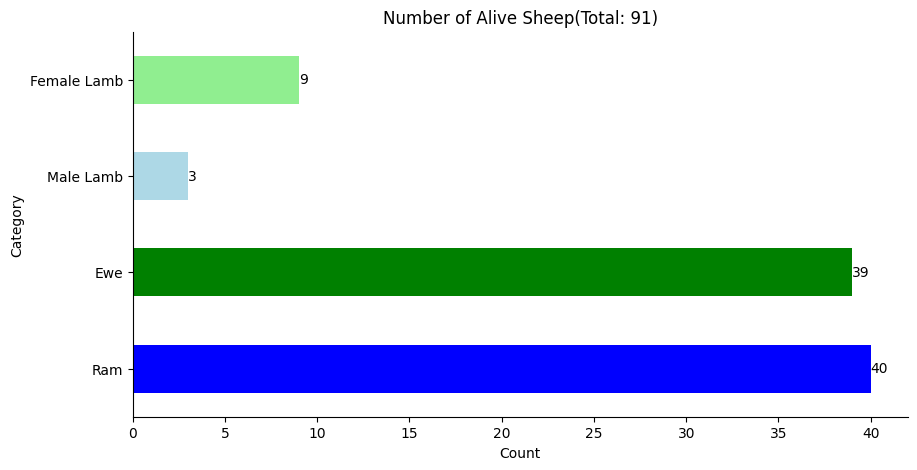

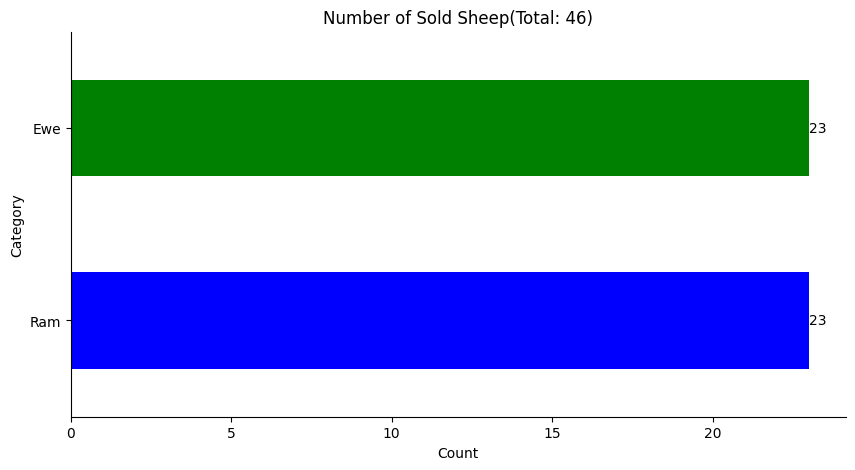

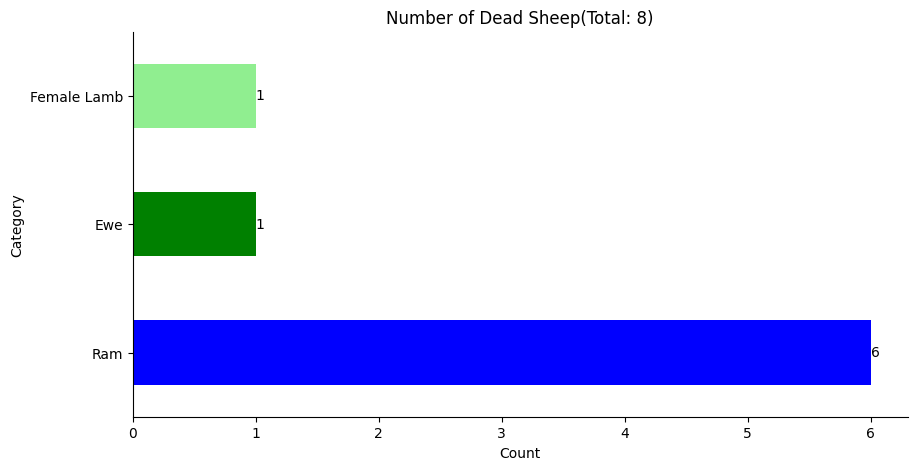

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns

# Ensure sheep_df is up-to-date, parsing 'birth_date' as dates
sheep_df = pd.read_sql_query("SELECT * FROM sheep", conn, parse_dates=['birth_date'])

# Categorize sheep into Ram, Ewe, Male Lamb, and Female Lamb based on age and gender
current_date = datetime.now()
def categorize_sheep(row):
    age_in_days = (current_date - row['birth_date']).days
    if age_in_days <= 180: # Approximately 6 months
        if row['gender'] == 'male':
            return 'Male Lamb'
        elif row['gender'] == 'female':
            return 'Female Lamb'
        else:
            return 'Lamb (Unknown Gender)' # Handle unknown gender for lambs
    else: # Older than 6 months
        if row['gender'] == 'male':
            return 'Ram'
        elif row['gender'] == 'female':
            return 'Ewe'
        else:
            return 'Adult (Unknown Gender)' # Handle unknown gender for adults

sheep_df['category'] = sheep_df.apply(categorize_sheep, axis=1)

# Define custom colors for each category
category_colors = {
    'Ram': 'blue',
    'Male Lamb': 'lightblue',
    'Ewe': 'green',
    'Female Lamb': 'lightgreen',
    'Lamb (Unknown Gender)': 'gray', # Default for unknown gender
    'Adult (Unknown Gender)': 'darkgray' # Default for unknown gender
}

# Order the categories for consistent plotting
ordered_categories = ['Ram', 'Ewe', 'Male Lamb', 'Female Lamb', 'Lamb (Unknown Gender)', 'Adult (Unknown Gender)']

# Define statuses to plot
statuses = ['alive', 'sold', 'dead']

for status in statuses:
    # Filter sheep by status
    status_df = sheep_df[sheep_df['status'] == status].copy()

    if not status_df.empty:
        # Group by category and count the number of sheep for the current status
        category_counts = status_df.groupby('category').size()

        # Reindex to include all categories, even if count is 0 for a status, and drop NaNs
        category_counts = category_counts.reindex(ordered_categories).dropna()

        # Get the total count for the current status
        total_count = status_df.shape[0]

        # Create the bar plot with custom colors
        colors = [category_colors[cat] for cat in category_counts.index]
        ax = category_counts.plot(kind='barh', color=colors, figsize=(10, 5))

        # Add the count values to the bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%d')

        plt.gca().spines[['top', 'right',]].set_visible(False)
        plt.xlabel('Count')
        plt.ylabel('Category')
        plt.title(f'Number of {status.capitalize()} Sheep(Total: {total_count})')
        plt.show()
    else:
        print(f"No sheep with status '{status}' to display.")

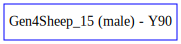

In [8]:
import graphviz

def visualize_pedigree(sheep_id, include_offspring=True, generations=2):
    conn = sqlite3.connect("sheep_management.db")
    cursor = conn.cursor()

    dot = graphviz.Digraph(comment=f'Pedigree for Sheep ID: {sheep_id}')
    added_nodes = set()

    def add_ancestors(current_sheep_id, current_generation):
        if current_generation > generations or current_sheep_id is None:
            return

        cursor.execute("SELECT * FROM sheep WHERE id = ?", (current_sheep_id,))
        sheep = cursor.fetchone()

        if sheep is None:
            return

        sheep_id, name, birth_date, ewe_id, ram_id, breed, gender, tag_id, status, notes = sheep

        if sheep_id not in added_nodes:
            color = 'blue' if current_generation == 0 else ('red' if gender == 'female' else 'green' if gender == 'male' else 'black')
            shape = 'box' if current_generation == 0 else 'ellipse'
            dot.node(sheep_id, f"{name} ({gender}) - {tag_id}", shape=shape, color=color)
            added_nodes.add(sheep_id)

        # Add parents and recurse
        if ewe_id:
            cursor.execute("SELECT * FROM sheep WHERE id = ?", (ewe_id,))
            ewe = cursor.fetchone()
            if ewe and ewe[0] not in added_nodes:
                 color = 'red' if ewe[6] == 'female' else 'green' if ewe[6] == 'male' else 'black'
                 dot.node(ewe[0], f"{ewe[1]} ({ewe[6]}) - {ewe[7]}", color=color)
                 added_nodes.add(ewe[0])
            if ewe:
                dot.edge(ewe_id, sheep_id, label="Mother")
                add_ancestors(ewe_id, current_generation + 1)

        if ram_id:
            cursor.execute("SELECT * FROM sheep WHERE id = ?", (ram_id,))
            ram = cursor.fetchone()
            if ram and ram[0] not in added_nodes:
                color = 'red' if ram[6] == 'female' else 'green' if ram[6] == 'male' else 'black'
                dot.node(ram[0], f"{ram[1]} ({ram[6]}) - {ram[7]}", color=color)
                added_nodes.add(ram[0])
            if ram:
                 dot.edge(ram_id, sheep_id, label="Father")
                 add_ancestors(ram_id, current_generation + 1)


    def add_offspring(current_sheep_id):
        if not include_offspring:
            return

        cursor.execute("SELECT * FROM sheep WHERE ewe_id = ? OR ram_id = ?", (current_sheep_id, current_sheep_id))
        offspring = cursor.fetchall()

        for youngone in offspring:
            sheep_id, name, birth_date, ewe_id, ram_id, breed, gender, tag_id, status, notes = youngone
            if sheep_id not in added_nodes:
                color = 'red' if gender == 'female' else 'green' if gender == 'male' else 'black'
                dot.node(youngone[0], f"{youngone[1]} ({youngone[6]}) - {youngone[7]}", color=color) # Node for offspring
                if youngone[3] == sheep_id: # If the target sheep is the mother
                    dot.edge(sheep_id, youngone[0], label="Offspring (Mother)")
                if youngone[4] == sheep_id: # If the target sheep is the father
                     dot.edge(sheep_id, youngone[0], label="Offspring (Father)")


    # Start with the target sheep
    add_ancestors(sheep_id, 0)
    add_offspring(sheep_id)


    return dot

# Example usage (replace with a valid sheep ID from your data)
# You might need to run the cell that registers sheep first to get valid IDs
# Find a sheep ID to visualize, for example, the first sheep in the dataframe
if not sheep_df.empty:
    example_sheep_id = sheep_df.iloc[100]['id']
    pedigree_graph = visualize_pedigree(example_sheep_id, include_offspring=True, generations=4) # Visualize 4 generations of ancestors
    display(pedigree_graph)
else:
    print("No sheep registered yet. Please register some sheep first.")

**Explanation:**

The code above defines a function `visualize_pedigree` that takes a sheep ID and an optional boolean `include_offspring` as input. It uses the `graphviz` library to create a directed graph representing the pedigree.

- Nodes in the graph represent individual sheep, labeled with their name, gender, and tag ID.
- The target sheep is highlighted with a blue box.
- Female parents (ewes) are shown in red, and male parents (rams) are shown in green.
- Offspring are also shown with colors indicating their gender (red for female, green for male).
- Edges between nodes indicate the parent-offspring relationship, with labels indicating whether the parent is the mother or father.

The example usage at the end of the cell demonstrates how to call the function and display the generated graph. Remember to replace the example sheep ID with a valid ID from your `sheep_df` DataFrame to visualize a specific sheep's pedigree.

In [9]:
# # 1. Register a sheep with the tag 'TESTTAG01' and status alive (should succeed)
# result1 = register_sheep("SheepAlive", "2024-01-01", None, None, "BreedA", "female", "TESTTAG01", "alive")
# print("Step 1 - First registration (should succeed):", result1)

# # 2. Try to register another living sheep with the same tag (should fail)
# result2 = register_sheep("SheepDupAlive", "2025-01-01", None, None, "BreedB", "male", "TESTTAG01", "alive")
# print("Step 2 - Registration with duplicate tag when alive (should fail):", result2)

# # 3. Mark the original sheep as dead and try again (should succeed)
# cursor.execute("UPDATE sheep SET status='dead' WHERE tag_id='TESTTAG01'")
# conn.commit()
# result3 = register_sheep("SheepAfterDead", "2025-02-01", None, None, "BreedC", "female", "TESTTAG01", "alive")
# print("Step 3 - Registration after dead (should succeed):", result3)

# # 4. Register another sheep and mark it as sold, then test reuse
# result4 = register_sheep("SheepSold", "2025-03-01", None, None, "BreedD", "male", "TESTTAG02", "sold")
# print("Step 4 - Registered and marked sold (should succeed):", result4)
# result5 = register_sheep("SheepReuseSold", "2025-04-01", None, None, "BreedE", "female", "TESTTAG02", "alive")
# print("Step 5 - Registration after sold (should succeed):", result5)

# # 5. Register sheep with a completely new tag for comparison (should succeed)
# result6 = register_sheep("SheepNewTag", "2025-05-01", None, None, "BreedF", "male", "TESTTAG03", "alive")
# print("Step 6 - Registration with a new tag (should succeed):", result6)



#4. Event Recording Function

In [20]:
def record_event(sheep_id, event_type, details):
    event_id = str(uuid.uuid4())
    event_date = datetime.now().strftime('%Y-%m-%d')
    cursor.execute("""
        INSERT INTO events (event_id, sheep_id, event_type, event_date, details)
        VALUES (?, ?, ?, ?, ?)
    """, (event_id, sheep_id, event_type, event_date, details))
    conn.commit()
    return event_id

# Use this function to log events such as birth, sale, death, movement, tagging, treatments, etc.


#5. Register Placeholder Sheep and Events

In [21]:
# Add sample sheep
sheep1_id = register_sheep("Daisy", "2023-01-10", None, None, "Merino", "female", "TAG001")
sheep2_id = register_sheep("Billy", "2022-11-15", None, None, "Dorper", "male", "TAG002")

# Record some events
record_event(sheep1_id, "birth", "Born at Kamureito farm")
record_event(sheep2_id, "birth", "Born at Kamureito farm")
record_event(sheep1_id, "tagging", "Ear tag applied: TAG001")
record_event(sheep2_id, "sale", "Sold to neighboring farm")

# Demonstrates registering and tracking sheep lifecycle events.


'1fbf074d-459b-43be-8919-8278789f7fce'

#6. Pedigree and Lineage Chart Query

In [12]:
def get_pedigree(sheep_id):
    cursor.execute("SELECT * FROM sheep WHERE id = ?", (sheep_id,))
    sheep = cursor.fetchone()
    if sheep is None:
        return f"No sheep found with ID: {sheep_id}"

    pedigree = {"Sheep": sheep}
    # Check ewe_id/mother
    if sheep[3]:
        cursor.execute("SELECT * FROM sheep WHERE id = ?", (sheep[3],))
        pedigree["Mother (Ewe)"] = cursor.fetchone()
    else:
        pedigree["Mother (Ewe)"] = None
    # Check ram_id/father
    if sheep[4]:
        cursor.execute("SELECT * FROM sheep WHERE id = ?", (sheep[4],))
        pedigree["Father (Ram)"] = cursor.fetchone()
    else:
        pedigree["Father (Ram)"] = None
    return pedigree

def get_pedigree(sheep_id):
    cursor.execute("SELECT * FROM sheep WHERE id = ?", (sheep_id,))
    sheep = cursor.fetchone()
    if sheep is None:
        return f"No sheep found with ID: {sheep_id}"

    # Get column headers for the sheep table
    headers = [desc[0] for desc in cursor.description]

    pedigree_records = []
    labels = []

    # Self
    pedigree_records.append(sheep)
    labels.append("Self")
    # Mother (Ewe)
    if sheep[3]:
        cursor.execute("SELECT * FROM sheep WHERE id = ?", (sheep[3],))
        mother = cursor.fetchone()
        pedigree_records.append(mother if mother else [None]*len(headers))
        labels.append("Mother (Ewe)")
    else:
        pedigree_records.append([None]*len(headers))
        labels.append("Mother (Ewe)")
    # Father (Ram)
    if sheep[4]:
        cursor.execute("SELECT * FROM sheep WHERE id = ?", (sheep[4],))
        father = cursor.fetchone()
        pedigree_records.append(father if father else [None]*len(headers))
        labels.append("Father (Ram)")
    else:
        pedigree_records.append([None]*len(headers))
        labels.append("Father (Ram)")

    df = pd.DataFrame(pedigree_records, columns=headers, index=labels)
    return df


# Print Daisy's pedigree (will show only herself as parents weren't set in placeholders)
sheep1_id = "28d8f8f8-22e5-4dd3-96da-548bfeaf47f6"
print(get_pedigree(sheep1_id))

# Replace with more sophisticated visualization as you expand system.


No sheep found with ID: 28d8f8f8-22e5-4dd3-96da-548bfeaf47f6


#7. Mating & Breeding Scheduling Functions and Demo


In [13]:
def schedule_breeding(female_id, male_id, suggested_date=None, gestation_days=150):
    breeding_id = str(uuid.uuid4())
    if not suggested_date:
        suggested_date = datetime.now().strftime('%Y-%m-%d')
    due_date = (datetime.strptime(suggested_date, '%Y-%m-%d') + timedelta(days=gestation_days)).strftime('%Y-%m-%d')
    cursor.execute("""
        INSERT INTO breeding (breeding_id, female_id, male_id, suggested_mating_date, gestation_due_date, status, notes)
        VALUES (?, ?, ?, ?, ?, ?, ?)
    """, (breeding_id, female_id, male_id, suggested_date, due_date, "scheduled", "Autogenerated"))
    conn.commit()
    return breeding_id

# Schedule a breeding event
breeding_event_id = schedule_breeding(sheep1_id, sheep2_id)
print(f"Breeding scheduled: {breeding_event_id}")

# This enables scheduling and reminders for matings and due dates.


Breeding scheduled: 08933a31-b434-4eb5-a307-4895187986ee


#8. Group and Individual Management Demo

In [14]:
# Show all sheep and events
sheep_df = pd.read_sql_query("SELECT * FROM sheep", conn)
events_df = pd.read_sql_query("SELECT * FROM events", conn)
print("Sheep List:")
print(sheep_df)
print("\nEvent Log:")
print(events_df)

# Analysis can be expanded for lambing patterns, growth rates, etc.


Sheep List:
                                       id            name  birth_date  \
0    0d5e0733-6082-42d3-a192-96751771a5b8  SourcedSheep_1  2019-03-18   
1    25b6ca5a-5388-4a96-8d50-ce80bfc00817  SourcedSheep_2  2019-07-10   
2    afeaa684-6291-4d0c-b48e-77eb926d9a0b  SourcedSheep_3  2019-02-20   
3    786e12ce-275a-4af1-90f2-f5d881efba9d  SourcedSheep_4  2019-05-11   
4    81e1c462-0090-47ce-bb30-a49c4fc92382  SourcedSheep_5  2019-03-20   
..                                    ...             ...         ...   
140  0d94d21f-7fc2-4ecc-a75d-a7ac7e2d26be    Gen6Sheep_18  2025-02-18   
141  a33ee13f-49c6-48df-8652-4bfc853fff89    Gen6Sheep_19  2025-03-15   
142  12725e59-f6a5-4e10-af52-f3e14c14f74a    Gen6Sheep_20  2025-04-10   
143  a8422532-be17-4d88-84fb-8e787f7527e3           Daisy  2023-01-10   
144  a97be07d-e317-4649-9847-4dea82c81b70           Billy  2022-11-15   

                                                ewe_id  \
0                                                 Non

#9. Population & Market Control & Inbreeding Prevention Placeholder

In [15]:
# Count total sheep, births, sales, deaths
def get_population_stats():
    stats = {}
    stats['total_sheep'] = cursor.execute("SELECT COUNT(*) FROM sheep WHERE status='alive'").fetchone()[0]
    stats['births'] = cursor.execute("SELECT COUNT(*) FROM events WHERE event_type='birth'").fetchone()[0]
    stats['sales'] = cursor.execute("SELECT COUNT(*) FROM events WHERE event_type='sale'").fetchone()[0]
    stats['deaths'] = cursor.execute("SELECT COUNT(*) FROM events WHERE event_type='death'").fetchone()[0]
    return stats

print("Population & Market Control:")
print(get_population_stats())

# Inbreeding Analysis (placeholder)
def check_inbreeding_risk(ewe_id, ram_id):
    # Fetch parents of both sheep
    cursor.execute("SELECT ewe_id, ram_id FROM sheep WHERE id = ?", (ewe_id,))
    ewe_parents = cursor.fetchone()
    cursor.execute("SELECT ewe_id, ram_id FROM sheep WHERE id = ?", (ram_id,))
    ram_parents = cursor.fetchone()

    # Compose response and check for shared parents
    if ewe_parents and ram_parents:
        shared = []
        if ewe_parents[0] and ewe_parents[0] == ram_parents[0]:  # shared mother
            shared.append("Shared mother (Ewe)")
        if ewe_parents[1] and ewe_parents[1] == ram_parents[1]:  # shared father
            shared.append("Shared father (Ram)")
        if shared:
            reason = " and ".join(shared)
            return f"High inbreeding risk! Reason: {reason}."
    return "No direct inbreeding risk detected."



print(check_inbreeding_risk(sheep1_id, sheep2_id))


Population & Market Control:
{'total_sheep': 145, 'births': 2, 'sales': 1, 'deaths': 0}
No direct inbreeding risk detected.


#10. Multi-user Support Placeholder

In [16]:
def register_user(name, role):
    user_id = str(uuid.uuid4())
    cursor.execute("INSERT INTO users (user_id, name, role) VALUES (?, ?, ?)", (user_id, name, role))
    conn.commit()
    return user_id

user1_id = register_user("Alice Kamureito", "Farm Manager")
user2_id = register_user("Bob Kamureito", "Assistant")

# List users
print(pd.read_sql_query("SELECT * FROM users", conn))

# Allows for multi-user records and mobile/app integration hooks.


                                user_id             name          role
0  2c1b235f-834b-4adb-b07d-d3961112b141  Alice Kamureito  Farm Manager
1  70fb0e6d-7340-4ed4-a457-722cbfc575de    Bob Kamureito     Assistant
